In [4]:
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior() 

In [1]:

import numpy as np
from attack_utils.patch_utils import extract_roi, evaluate_vanishing_patch, evaluate_mislabeling_patch
from dataset_utils.preprocessing import letterbox_image_padded

from models.yolov3 import YOLOv3_Darknet53
#from models.ssd import SSD300
from misc_utils.visualization import visualize_detections
from keras import backend as K
from tqdm import tqdm
from PIL import Image
#from keras.legacy_tf_layers import BatchNormalization
#from keras.layers.normalization import batch_normalization
import datetime
import os
K.clear_session()

Using TensorFlow backend.


In [2]:
weights = '/home/tihaam/Downloads/TOG-master/assets/YOLOv3_Darknet53.h5'  # TODO: Change this path to the victim model's weights
#weights = '/research/projects/robust-object-detection/model_weights/YOLOv3_VOC0712_Darknet53.h5'  # TODO: Change this path to the victim model's weights

detector = YOLOv3_Darknet53(weights=weights)

#weights = '/home/tihaam/Downloads/TOG-master/ssd_utils/SSD300.h5'  # TODO: Change this path to the victim model's weights

#detector = SSD300(weights=weights)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2021-10-09 02:03:38.295713: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-09 02:03:38.296496: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2021-10-09 02:03:38.296523: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: tihaam-Predator-PH315-51
2021-10-09 02:03:38.296530: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: tihaam-Predator-PH315-51
2021-10-09 02:03:38.296580: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 384.130.0
2021-10-09 02:03:38.296607: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 384.130.0
2021-10-09 02:03:38.296614: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version see

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Configuration of Attack Hyperparameters

In [17]:
ROOT_TRAIN = '/home/tihaam/Downloads/INRIAPerson/Train/pos'
ROOT_TEST = '/home/tihaam/Downloads/INRIAPerson/Test/pos'
ROOT_OUTPUT = './outputs'
NUM_EPOCHS = 100
LR_INIT = 0.1
LR_MULTIPLIER = 0.1
BATCH_SIZE = 8
TOLERANCE_MAX = 5
TOLERANCE_DELTA = 0.01
PATCH_SIZE = (64, 64)
MIN_ROI_SIZE = PATCH_SIZE[0] * PATCH_SIZE[1] * 3
SOURCE_CLASS = 'person'
TARGET_CLASS = 'chair'
fpaths_train = [os.path.join(ROOT_TRAIN, fname) for fname in os.listdir(ROOT_TRAIN)]
fpaths_test = [os.path.join(ROOT_TEST, fname) for fname in os.listdir(ROOT_TEST)]

ERROR! Session/line number was not unique in database. History logging moved to new session 204


In [18]:
patch = np.full(shape=(1, *PATCH_SIZE, 3), fill_value=0.50)
min_loss = np.float('inf')
tolerance = 0
lr = LR_INIT

output_folder = os.path.join(ROOT_OUTPUT, 'vanishing',
                             '%s_%s' % (datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S"), SOURCE_CLASS))
os.makedirs(output_folder)

In [ ]:
for epoch in range(NUM_EPOCHS):
    ####################################################################################################################
    # Training
    ####################################################################################################################
    epoch_loss = []
    batch_grad, batch_loss = [], []
    np.random.shuffle(fpaths_train)
    for fpath in tqdm(fpaths_train):
        # Preprocess input images
        input_img = Image.open(fpath)
        
        x_nat, x_bbox = letterbox_image_padded(input_img, size=detector.model_img_size)

        # Get roi candidates with an area higher than a predefined threshold to avoid trivial attacks
        detections_nat = detector.detect(x_nat)
        rois = extract_roi(detections_nat, detector.classes.index(SOURCE_CLASS), x_bbox, min_size=MIN_ROI_SIZE, patch_size=PATCH_SIZE)
        if len(rois) == 0:
            continue

        # Apply adversarial patch to each of the rois
        x_adv = x_nat.copy()
        detections_target = detections_nat.copy()
        for _, _, (xmin, ymin, xmax, ymax), did in rois:
            x_adv[:, ymin:ymax, xmin:xmax, :] = patch
        
        # Compute gradients
        grad, loss = detector.compute_object_vanishing_gradient_and_loss(x_adv, detections=detections_target)

        # Clip gradients to the area where the adversarial patch is located
        grad = np.mean([grad[:, ymin:ymax, xmin:xmax, :] for _, _, (xmin, ymin, xmax, ymax), _ in rois], axis=0)
        batch_grad.append(grad)
        batch_loss.append(loss)

        if len(batch_loss) == BATCH_SIZE:  # Update the adversarial patch and log the loss over the mini-batch
            patch = np.clip(patch - lr * np.mean(batch_grad, axis=0), 0.0, 1.0)
            epoch_loss.append(np.mean(batch_loss))
            batch_grad, batch_loss = [], []

    ####################################################################################################################
    # Testing
    ####################################################################################################################
    # Baseline = Random permutation of the adversarial patch (i.e., decorrelating pixels)
    patch_rand = np.reshape(patch.copy(), newshape=(patch.shape[0]*patch.shape[1]*patch.shape[2], patch.shape[3]))
    np.random.shuffle(patch_rand)
    patch_rand = np.reshape(patch_rand, newshape=patch.shape)
    num_rois, score_adv, score_rand = 0, 0, 0
    for fpath in fpaths_test:
        input_img = Image.open(fpath)
        x_nat, x_bbox = letterbox_image_padded(input_img, size=detector.model_img_size)

        # Get roi candidates with an area higher than a predefined threshold to avoid trivial attacks
        detections_nat = detector.detect(x_nat)
        rois = extract_roi(detections_nat, detector.classes.index(SOURCE_CLASS), x_bbox, min_size=MIN_ROI_SIZE, patch_size=PATCH_SIZE)
        num_rois_x = len(rois)
        if num_rois_x == 0:
            continue

        x_adv, x_rand = x_nat.copy(), x_nat.copy()
        for _, _, (xmin, ymin, xmax, ymax), _ in rois:
            x_adv[:, ymin:ymax, xmin:xmax, :] = patch
            x_rand[:, ymin:ymax, xmin:xmax, :] = patch_rand
        detections_adv = detector.detect(x_adv)
        detections_rand = detector.detect(x_rand)

        score_adv_x, score_rand_x = evaluate_vanishing_patch(detector.classes.index(SOURCE_CLASS), rois, detections_adv, detections_rand)
        score_adv += score_adv_x
        score_rand += score_rand_x
        num_rois += num_rois_x

    # Compute training statistics
    epoch_loss = float(np.mean(epoch_loss))
    ASR_TOG = score_adv / num_rois
    ASR_Rand = score_rand / num_rois

    # Save the adversarial patch
    np.save(os.path.join(output_folder, 'Epoch-%d_Loss-%.2f_ASR-%.2f.npy' % (epoch, epoch_loss, ASR_TOG)), patch)

    # Monitor training loss for learning rate scheduling
    if epoch_loss > min_loss - TOLERANCE_DELTA:
        tolerance += 1
        if tolerance >= TOLERANCE_MAX:
            lr *= LR_MULTIPLIER
            tolerance = 0
    else:
        tolerance = 0
    min_loss = min(min_loss, epoch_loss)

    # Print training progress
    print('[Epoch %d] LR: %f | Tol: %d/%d | Min. Loss: %.4f' % (epoch, lr, tolerance + 1, TOLERANCE_MAX, min_loss))
    print('  > Loss      : %.4f' % epoch_loss)
    print('  > ASR (TOG) : %d/%d = %.2f' % (score_adv, num_rois, ASR_TOG))
    print('  > ASR (Rand): %d/%d = %.2f' % (score_rand, num_rois, ASR_Rand))

100%|█████████████████████████████████████████| 614/614 [25:38<00:00,  2.50s/it]


[Epoch 0] LR: 0.100000 | Tol: 1/5 | Min. Loss: 26.2641
  > Loss      : 26.2641
  > ASR (TOG) : 76/226 = 0.34
  > ASR (Rand): 2/226 = 0.01


100%|█████████████████████████████████████████| 614/614 [25:29<00:00,  2.49s/it]


[Epoch 1] LR: 0.100000 | Tol: 1/5 | Min. Loss: 23.1003
  > Loss      : 23.1003
  > ASR (TOG) : 103/226 = 0.46
  > ASR (Rand): 2/226 = 0.01


100%|█████████████████████████████████████████| 614/614 [25:31<00:00,  2.49s/it]


[Epoch 2] LR: 0.100000 | Tol: 1/5 | Min. Loss: 21.9317
  > Loss      : 21.9317
  > ASR (TOG) : 120/226 = 0.53
  > ASR (Rand): 2/226 = 0.01


100%|█████████████████████████████████████████| 614/614 [25:31<00:00,  2.49s/it]


[Epoch 3] LR: 0.100000 | Tol: 1/5 | Min. Loss: 20.9664
  > Loss      : 20.9664
  > ASR (TOG) : 148/226 = 0.65
  > ASR (Rand): 2/226 = 0.01


100%|█████████████████████████████████████████| 614/614 [25:31<00:00,  2.49s/it]


[Epoch 4] LR: 0.100000 | Tol: 1/5 | Min. Loss: 20.5088
  > Loss      : 20.5088
  > ASR (TOG) : 156/226 = 0.69
  > ASR (Rand): 2/226 = 0.01


100%|█████████████████████████████████████████| 614/614 [25:33<00:00,  2.50s/it]


[Epoch 5] LR: 0.100000 | Tol: 1/5 | Min. Loss: 19.9405
  > Loss      : 19.9405
  > ASR (TOG) : 158/226 = 0.70
  > ASR (Rand): 2/226 = 0.01


100%|█████████████████████████████████████████| 614/614 [27:08<00:00,  2.65s/it]


[Epoch 6] LR: 0.100000 | Tol: 1/5 | Min. Loss: 19.6302
  > Loss      : 19.6302
  > ASR (TOG) : 162/226 = 0.72
  > ASR (Rand): 1/226 = 0.00


100%|█████████████████████████████████████████| 614/614 [26:51<00:00,  2.63s/it]


[Epoch 7] LR: 0.100000 | Tol: 1/5 | Min. Loss: 19.1671
  > Loss      : 19.1671
  > ASR (TOG) : 164/226 = 0.73
  > ASR (Rand): 2/226 = 0.01


100%|█████████████████████████████████████████| 614/614 [26:03<00:00,  2.55s/it]


[Epoch 8] LR: 0.100000 | Tol: 1/5 | Min. Loss: 18.8646
  > Loss      : 18.8646
  > ASR (TOG) : 170/226 = 0.75
  > ASR (Rand): 1/226 = 0.00


100%|█████████████████████████████████████████| 614/614 [26:12<00:00,  2.56s/it]


[Epoch 9] LR: 0.100000 | Tol: 1/5 | Min. Loss: 18.6066
  > Loss      : 18.6066
  > ASR (TOG) : 173/226 = 0.77
  > ASR (Rand): 2/226 = 0.01


100%|█████████████████████████████████████████| 614/614 [25:33<00:00,  2.50s/it]


[Epoch 10] LR: 0.100000 | Tol: 1/5 | Min. Loss: 18.4138
  > Loss      : 18.4138
  > ASR (TOG) : 179/226 = 0.79
  > ASR (Rand): 2/226 = 0.01


100%|█████████████████████████████████████████| 614/614 [25:32<00:00,  2.50s/it]


[Epoch 11] LR: 0.100000 | Tol: 1/5 | Min. Loss: 18.1398
  > Loss      : 18.1398
  > ASR (TOG) : 177/226 = 0.78
  > ASR (Rand): 2/226 = 0.01


100%|█████████████████████████████████████████| 614/614 [25:32<00:00,  2.50s/it]


[Epoch 12] LR: 0.100000 | Tol: 1/5 | Min. Loss: 17.9192
  > Loss      : 17.9192
  > ASR (TOG) : 184/226 = 0.81
  > ASR (Rand): 1/226 = 0.00


100%|█████████████████████████████████████████| 614/614 [25:34<00:00,  2.50s/it]


[Epoch 13] LR: 0.100000 | Tol: 1/5 | Min. Loss: 17.5951
  > Loss      : 17.5951
  > ASR (TOG) : 185/226 = 0.82
  > ASR (Rand): 1/226 = 0.00


100%|█████████████████████████████████████████| 614/614 [25:31<00:00,  2.49s/it]


[Epoch 14] LR: 0.100000 | Tol: 1/5 | Min. Loss: 17.3308
  > Loss      : 17.3308
  > ASR (TOG) : 185/226 = 0.82
  > ASR (Rand): 2/226 = 0.01


100%|█████████████████████████████████████████| 614/614 [25:31<00:00,  2.49s/it]


[Epoch 15] LR: 0.100000 | Tol: 2/5 | Min. Loss: 17.3308
  > Loss      : 17.3759
  > ASR (TOG) : 186/226 = 0.82
  > ASR (Rand): 2/226 = 0.01


 12%|████▉                                     | 72/614 [03:09<23:45,  2.63s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/tihaam/miniconda2/envs/vod3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_14934/2789278351.py", line 15, in <module>
    detections_nat = detector.detect(x_nat)
  File "/home/tihaam/Downloads/TOG-master/models/yolov3.py", line 91, in detect
    encoded_detections = self.model.predict(x)
  File "/home/tihaam/miniconda2/envs/vod3/lib/python3.7/site-packages/keras/engine/training.py", line 1462, in predict
    callbacks=callbacks)
  File "/home/tihaam/miniconda2/envs/vod3/lib/python3.7/site-packages/keras/engine/training_arrays.py", line 324, in predict_loop
    batch_outs = f(ins_batch)
  File "/home/tihaam/miniconda2/envs/vod3/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3476, in __call__
    run_metadata=self.run_metadata)
  File "/home/tihaam/miniconda2/envs/vod3/lib/python3.7/site-packages/t

## Testing TOG-vanishing Adversarial Patch

In [ ]:
import imageio

reader = imageio.get_reader('./assets/personvid.mp4')
#np.uint8(cm.gist_earth(myarray)*255)
w = imageio.get_writer('./assets/attackperson_videobenign.mp4', format='FFMPEG', mode='I', fps=20)
for i, im in enumerate(reader):
    
    pil_img = Image.fromarray(im)
    x_query, x_meta = letterbox_image_padded(pil_img, size=detector.model_img_size)
    detections_query = detector.detect(x_query, conf_threshold=detector.confidence_thresh_default)

    # Get roi candidates with an area higher than a predefined threshold to avoid trivial attacks
    rois = extract_roi(detections_query, detector.classes.index(SOURCE_CLASS), x_meta, min_size=MIN_ROI_SIZE, patch_size=PATCH_SIZE)

    # Apply adversarial patch to each of the rois
    x_adv, x_rand = x_query.copy(), x_query.copy()
    for _, _, (xmin, ymin, xmax, ymax), did in rois:
        x_adv[:, ymin:ymax, xmin:xmax, :] = patch
        x_rand[:, ymin:ymax, xmin:xmax, :] = patch_rand
    detections_adv = detector.detect(x_adv, conf_threshold=detector.confidence_thresh_default)
    detections_rand = detector.detect(x_rand, conf_threshold=detector.confidence_thresh_default)
    ddd=visualize_detections({'Benign': (x_query, detections_query, detector.model_img_size, detector.classes)})
    if i==50:
        break;
    w.append_data(ddd)
w.close()
    #print(pil_img)

[swscaler @ 0x55afafdf8300] Warning: data is not aligned! This can lead to a speed loss


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

<Figure size 432x288 with 0 Axes>

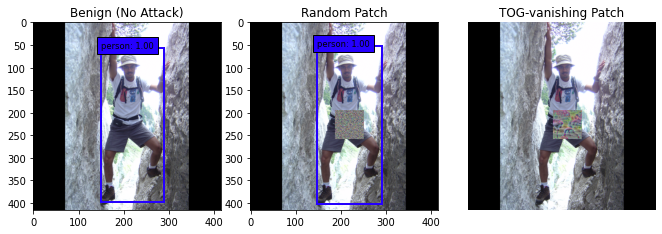

In [30]:
fpath = '/home/tihaam/Downloads/INRIAPerson/Train/pos/crop001019.png'    # TODO: Change this path to the image to be attacked

input_img = Image.open(fpath)
x_query, x_meta = letterbox_image_padded(input_img, size=detector.model_img_size)
detections_query = detector.detect(x_query, conf_threshold=detector.confidence_thresh_default)

# Get roi candidates with an area higher than a predefined threshold to avoid trivial attacks
rois = extract_roi(detections_query, detector.classes.index(SOURCE_CLASS), x_meta, min_size=MIN_ROI_SIZE, patch_size=PATCH_SIZE)

# Apply adversarial patch to each of the rois
x_adv, x_rand = x_query.copy(), x_query.copy()
for _, _, (xmin, ymin, xmax, ymax), did in rois:
    x_adv[:, ymin:ymax, xmin:xmax, :] = patch
    x_rand[:, ymin:ymax, xmin:xmax, :] = patch_rand
detections_adv = detector.detect(x_adv, conf_threshold=detector.confidence_thresh_default)
detections_rand = detector.detect(x_rand, conf_threshold=detector.confidence_thresh_default)
visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                      'Random Patch': (x_rand, detections_rand, detector.model_img_size, detector.classes),
                      'TOG-vanishing Patch': (x_adv, detections_adv, detector.model_img_size, detector.classes)})